In [16]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import time
from keras.callbacks import EarlyStopping

In [38]:
import math
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU
from keras.layers import LSTM, Dropout, BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import time
from keras.callbacks import EarlyStopping

In [77]:
wut = pd.read_pickle('../../../data/features&predictions_haarsteeg.pkl')
march = wut[wut['month'] == '3']
# wut.columns
# wut[['month']].dtypes
march[march['day_ofthe_month'] == '31']

,day_ofthe_month,hour,day_ofthe_year,day_ofthe_week,holiday,flow,month,year,level_lag_-15,level_lag_-14,...,rain_lag_-4,rain_lag_-3,rain_lag_-2,rain_lag_-1,rain_hour,level,rain_N_ago,dates,predictions,Begin
2136,31,0,90,5,0,0.0,3,2018,0.000000,0.000000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.000000,1,2018-03-31 00:00:00,266.271952,2018-03-31 00:00:00
2137,31,1,90,5,0,0.0,3,2018,0.000000,0.000000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.000000,1,2018-03-31 01:00:00,616.629279,2018-03-31 01:00:00
2138,31,2,90,5,0,0.0,3,2018,0.000000,0.000000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.000000,1,2018-03-31 02:00:00,1814.761700,2018-03-31 02:00:00
2139,31,3,90,5,0,0.0,3,2018,0.000000,0.000000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.000000,1,2018-03-31 03:00:00,3318.431570,2018-03-31 03:00:00
2140,31,4,90,5,0,0.0,3,2018,0.000000,0.000000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.000000,1,2018-03-31 04:00:00,3293.355449,2018-03-31 04:00:00
2141,31,5,90,5,0,0.0,3,2018,0.000000,0.000000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.000000,1,2018-03-31 05:00:00,6736.059580,2018-03-31 05:00:00
2142,31,6,90,5,0,0.0,3,2018,0.000000,0.000000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.000000,1,2018-03-31 06:00:00,8319.163456,2018-03-31 06:00:00
2143,31,7,90,5,0,0.0,3,2018,0.000000,0.000000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.000000,1,2018-03-31 07:00:00,10931.775021,2018-03-31 07:00:00
2144,31,8,90,5,0,0.0,3,2018,0.000000,0.000000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.000000,1,2018-03-31 08:00:00,10031.608836,2018-03-31 08:00:00
2145,31,9,90,5,0,0.0,3,2018,0.000000,0.000000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.000000,1,2018-03-31 09:00:00,15267.091665,2018-03-31 09:00:00


In [24]:
other = pd.read_csv('../../../data/Helftheuvelweg_flowrainlevel.csv')
other = other.rename(columns={"Hertogenbosch (Helftheuvelweg)": "rain"})
other['rain'] = other['rain'] * 7690666495.734759
other['datetime'] = pd.to_datetime(other['timestamp_new'])
other

,timestamp_new,flow,rain,level,datetime
0,2018-01-02 00:00:00,1251.321667,4.941554e+05,191.130220,2018-01-02 00:00:00
1,2018-01-02 01:00:00,875.805000,3.596787e+06,197.317824,2018-01-02 01:00:00
2,2018-01-02 02:00:00,509.238333,6.156250e+06,214.689623,2018-01-02 02:00:00
3,2018-01-02 03:00:00,399.153333,9.928292e+06,215.893369,2018-01-02 03:00:00
4,2018-01-02 04:00:00,526.338333,6.111256e+06,202.070086,2018-01-02 04:00:00
...,...,...,...,...,...
14539,2019-08-30 20:00:00,NaN,0.000000e+00,199.110922,2019-08-30 20:00:00
14540,2019-08-30 21:00:00,NaN,0.000000e+00,215.547488,2019-08-30 21:00:00
14541,2019-08-30 22:00:00,NaN,0.000000e+00,215.227521,2019-08-30 22:00:00
14542,2019-08-30 23:00:00,NaN,0.000000e+00,213.233992,2019-08-30 23:00:00


In [23]:
(data[['flow']]/100).describe()

,flow
count,13630.000000
mean,284.419944
std,198.522634
min,0.000000
25%,171.439000
50%,269.473000
75%,334.415500
max,2100.000000


In [29]:
# prepare dfs
boi = other[['timestamp_new', 'flow']]

data['new_flow'] = data['flow'] / 100
our = data[['datetime', 'new_flow']]
our = our.rename(columns={"datetime": "timestamp_new", "new_flow": "flow"})
our

,timestamp_new,flow
0,2018-01-01 00:00:00,782.002
1,2018-01-01 01:00:00,580.775
2,2018-01-01 02:00:00,485.555
3,2018-01-01 03:00:00,439.461
4,2018-01-01 04:00:00,463.072
...,...,...
13625,2019-08-23 19:00:00,336.289
13626,2019-08-23 20:00:00,218.292
13627,2019-08-23 21:00:00,392.737
13628,2019-08-23 22:00:00,235.345


In [31]:
our.describe()

,flow
count,13630.000000
mean,284.419944
std,198.522634
min,0.000000
25%,171.439000
50%,269.473000
75%,334.415500
max,2100.000000


In [33]:
boi.describe()

,flow
count,14376.000000
mean,478.116071
std,338.600603
min,0.000000
25%,289.217500
50%,448.161667
75%,559.546667
max,3558.333333


In [30]:
pd.merge(our, boi, how='inner')

,timestamp_new,flow
0,2018-02-27 12:00:00,0.0
1,2018-02-27 13:00:00,0.0
2,2018-02-27 14:00:00,0.0
3,2018-02-27 15:00:00,0.0
4,2018-02-27 16:00:00,0.0
...,...,...
109,2019-08-20 09:00:00,0.0
110,2019-08-20 10:00:00,0.0
111,2019-08-20 11:00:00,0.0
112,2019-08-20 12:00:00,0.0


### General notes
Need to save the original flow to compare predictions to > DONE

Currently I use lags as separate features, tho it might be more beneficial to use sequences (aka sequence becomes a single feature), so a new prediction is made based on the sequence of 24 past values
so use red data to predict the one blue datapoint
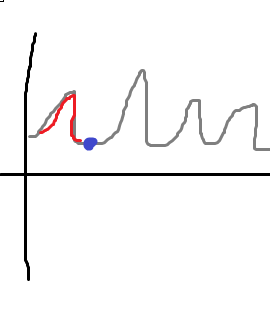
__should be doing this now woop__

main issue: how to add extra features next to lags > eh don't really need this

# to do:
- fix scaling back to original scale
- decide on how to select out train validation and test

# nice functions wohooooooo 

In [3]:
def Normalize(df, cols):
    """
    Input:  df - df for which you want to normalize columns
            cols - list of names of the columns (str)
    Output: same df but better
    """
    for col in cols:
        # first get a numpy array of col so that the scaler can be applied
        col_np = df[col].to_numpy().reshape(-1, 1)
    
        # apply the scaler
        scaler = MinMaxScaler(feature_range=(0, 1))
        col_np = scaler.fit_transform(col_np)

        # add column back to df
        df[f'norm_{col}'] = col_np
        
        # drop old non normalized col from df 
        df = df.drop([col], axis=1)
    
    return df


def CreateLags(df, cols, lag_num):
    """
    Input:  df - df that you want to add lags to
            cols - list of names of the columns (str)
            lag_num - number of desired lags
    Output: df with lags 
    """
    shift_dfs = []
    for col in cols:
        # These are the "time lags"
        shifts = np.arange(1, lag_num+1).astype(int)
        # Use a dictionary comprehension to create name: value pairs, one pair per shift
        shifted_data_col = {col + "_lag_{}_hour".format(hour_shift): df[col].shift(hour_shift) for hour_shift in shifts}
        # Convert into a DataFrame for subsequent use
        col_shifts = pd.DataFrame(shifted_data_col)
        shift_dfs.append(col_shifts)
    # combine the shifted data with df
    df_shifted = pd.concat([df] + shift_dfs, axis=1)

    return df_shifted


def DropNAN(df):
    len1 = len(df)
#     print('Shape before NAN removal: ', df.shape)
    df.dropna(inplace=True)
    len2 = len(df)
#     print('Shape after NAN removal:  ', df.shape)
    print(len1-len2, 'rows were removed because of NANs')
    
    return df


def GetXY(df):
    # works assuming the predictor variable is the first column in df
    
    # create the X and y dataset
    X = df.iloc[:, 1:] # every columns exept current flow
    y = df.iloc[:, :1] # only the current flow columns
    
    # and make them into numpy arrays
    X = X.values
    y = y.values
    
    return X, y


def TrainTestSklearn(X, y): # this is pretty useless lol, i was tired
    """
    Function that will select roughly the first 15 months of data as train and rest as test
    
    Input:  X - numpy array of predictor variables
            y - numpy array of the target variable
    Output: train and test sets
    """    
#     return X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.78, test_size=.22, shuffle=False, random_state=1)


# def TrainValidTest(df, index1, index2):
    

In [4]:
def Preprocess(df):
    
    # drop everything unnecessary
    new_df = df[['flow', 'rain_hour', 'level']]
    
    # normalize the columns
    new_df = Normalize(new_df, ['flow', 'rain_hour', 'level'])
    
    # create 24 lags of flow, rain and level
    new_df = CreateLags(new_df, ['norm_flow', 'norm_rain_hour', 'norm_level'], 24)
    
    # remove NANs
    new_df = DropNAN(new_df)
    
    # drop columns for current rain and level as we only want to use lags for predictions
    new_df = new_df.drop(['norm_rain_hour', 'norm_level'], axis=1)
    
    # separate predictors columns and target column and save them in numpy arrays
    X, y = GetXY(new_df)
    print(X.shape, y.shape)
    
    return X, y


In [65]:
# Load dataframes and scale them properly
path = '../../../data/'
pumps = ['Hertogenbosch (Helftheuvelweg)','Bokhoven','Hertogenbosch (Maasport)', 'Hertogenbosch (Oude Engelenseweg)', 'Hertogenbosch (Rompert)']

def Get_Data(pumps, path):
    '''
    In: list of all the pump names to refer to datasets
        path were the data files are located
    Out: Dictionary that contains all preprocessed Datasets
    '''
    
    scaler_flow = MinMaxScaler(feature_range=(0, 1))
    scaler_rain = MinMaxScaler(feature_range=(0, 1))
    scaler_level = MinMaxScaler(feature_range=(0, 1))
    dfs = {}
    for pump in pumps:
        data = pd.read_pickle(path + pump + '.pickle')
        new_df = data[['flow', 'rain_hour', 'level']]
        if pump != 'Bokhoven' or pump != 'Haarsteeg':
            new_df['flow'] = data['flow']/100
            new_df['level'] = data['level']/1000
            
        new_df['norm_flow'] = scaler_flow.fit_transform(new_df[['flow']])
        # scale rain
        new_df['norm_rain_hour'] = scaler_rain.fit_transform(new_df[['rain_hour']])
        # scale level
        new_df['norm_level'] = scaler_level.fit_transform(new_df[['level']])

        # drop nonscaled flow, rain, level
        new_df = new_df.drop(['flow', 'rain_hour', 'level'], axis=1)
        
        # create 24 lags of flow, rain and level
        new_df = CreateLags(new_df, ['norm_flow', 'norm_rain_hour', 'norm_level'], 24)

        # remove NANs
        new_df = DropNAN(new_df)

        # drop columns for current rain and level as we only want to use lags for predictions
        new_df = new_df.drop(['norm_rain_hour', 'norm_level'], axis=1)
        dfs[pump] = new_df
    return dfs

# Start here

In [66]:
# # new pickle data
# data = pd.read_pickle('../../../data/Hertogenbosch (Helftheuvelweg).pickle')

# # sort by time just in case
# data = data.sort_values(by='datetime')

# # basic metrics for original data
# data[['flow']].describe()

In [67]:
new_df = Get_Data(pumps, path)

C:\Users\maren\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\maren\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\maren\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

24 rows were removed because of NANs


C:\Users\maren\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\maren\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\maren\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

24 rows were removed because of NANs


C:\Users\maren\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\maren\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\maren\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

24 rows were removed because of NANs


C:\Users\maren\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\maren\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\maren\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

24 rows were removed because of NANs


C:\Users\maren\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\maren\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\maren\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

24 rows were removed because of NANs


C:\Users\maren\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [63]:
for pump in pumps:
    new_df[pump].to_csv(path + f'/model_data/{pump}.csv')

In [49]:
new_df.keys()

dict_keys(['Hertogenbosch (Helftheuvelweg)', 'Bokhoven', 'Hertogenbosch (Maasport)', 'Hertogenbosch (Oude Engelenseweg)', 'Hertogenbosch (Rompert)'])

In [51]:
new_df[pumps[0]].head()

,norm_flow,norm_flow_lag_1_hour,norm_flow_lag_2_hour,norm_flow_lag_3_hour,norm_flow_lag_4_hour,norm_flow_lag_5_hour,norm_flow_lag_6_hour,norm_flow_lag_7_hour,norm_flow_lag_8_hour,norm_flow_lag_9_hour,...,norm_level_lag_15_hour,norm_level_lag_16_hour,norm_level_lag_17_hour,norm_level_lag_18_hour,norm_level_lag_19_hour,norm_level_lag_20_hour,norm_level_lag_21_hour,norm_level_lag_22_hour,norm_level_lag_23_hour,norm_level_lag_24_hour
24,0.308624,0.416750,0.556805,0.712757,0.736824,0.624386,0.475200,0.348697,0.155275,0.176415,...,0.475977,0.406888,0.482689,0.492885,0.407138,0.405748,0.446184,0.436118,0.400332,0.438775
25,0.203042,0.308624,0.416750,0.556805,0.712757,0.736824,0.624386,0.475200,0.348697,0.155275,...,0.409861,0.475977,0.406888,0.482689,0.492885,0.407138,0.405748,0.446184,0.436118,0.400332
26,0.120231,0.203042,0.308624,0.416750,0.556805,0.712757,0.736824,0.624386,0.475200,0.348697,...,0.459098,0.409861,0.475977,0.406888,0.482689,0.492885,0.407138,0.405748,0.446184,0.436118
27,0.092757,0.120231,0.203042,0.308624,0.416750,0.556805,0.712757,0.736824,0.624386,0.475200,...,0.497844,0.459098,0.409861,0.475977,0.406888,0.482689,0.492885,0.407138,0.405748,0.446184
28,0.178081,0.092757,0.120231,0.203042,0.308624,0.416750,0.556805,0.712757,0.736824,0.624386,...,0.361629,0.497844,0.459098,0.409861,0.475977,0.406888,0.482689,0.492885,0.407138,0.405748


In [56]:
# separate predictors columns and target column and save them in numpy arrays
X, y = dict(), dict()
X_train, X_test, y_train, y_test = dict(), dict(), dict(), dict()
for pump in pumps:
    X[pump], y[pump] = GetXY(new_df[pump])
    print(f'X shape for {pump}: ', X[pump].shape, y[pump].shape)
    X_train[pump], X_test[pump], y_train[pump], y_test[pump] = train_test_split(X[pump], y[pump], train_size=.78, test_size=.22, shuffle=False, random_state=1)
    print(f'X_Train shape for {pump}: ', X_train[pump].shape, 'X_test shape for {pump}: ', X_test[pump].shape)

X shape for Hertogenbosch (Helftheuvelweg):  (13606, 72) (13606, 1)
X_Train shape for Hertogenbosch (Helftheuvelweg):  (10612, 72) X_test shape for {pump}:  (2994, 72)
X shape for Bokhoven:  (14375, 72) (14375, 1)
X_Train shape for Bokhoven:  (11212, 72) X_test shape for {pump}:  (3163, 72)
X shape for Hertogenbosch (Maasport):  (13126, 72) (13126, 1)
X_Train shape for Hertogenbosch (Maasport):  (10238, 72) X_test shape for {pump}:  (2888, 72)
X shape for Hertogenbosch (Oude Engelenseweg):  (13606, 72) (13606, 1)
X_Train shape for Hertogenbosch (Oude Engelenseweg):  (10612, 72) X_test shape for {pump}:  (2994, 72)
X shape for Hertogenbosch (Rompert):  (13126, 72) (13126, 1)
X_Train shape for Hertogenbosch (Rompert):  (10238, 72) X_test shape for {pump}:  (2888, 72)


In [57]:
# save number of lags and number of features in variables
n_hours = 24
n_features = 3 # flow, rain, level

for pump in pumps:
    # reshape X_train and X_test for the LSTM layer
    X_train[pump] = np.reshape(X_train[pump], (X_train[pump].shape[0], n_hours, n_features))
    X_test[pump] = np.reshape(X_test[pump], (X_test[pump].shape[0], n_hours, n_features))


#### Start with model

In [58]:
model = Sequential()
model.add(LSTM(256, input_shape=(n_hours, n_features), return_sequences=True))
#model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(LSTM(128))
#model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mae', metrics = ['mse', 'mae'], optimizer='adamax')

In [ ]:
history = dict()
for pump in pumps:
    history[pump] = model.fit(X_train[pump], y_train[pump], epochs=50, validation_split=0.2, verbose=1, shuffle=False)

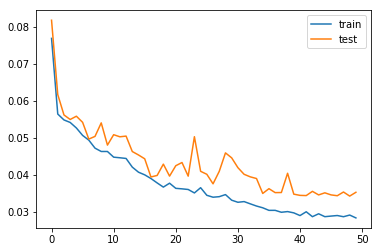

In [40]:
# plot history
for pump in pumps:
    plt.plot(history[pump].history['loss'], label='train')
    plt.plot(history[pump].history['val_loss'], label='test')
    plt.legend()
    plt.show()

In [41]:
# make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [45]:
# invert the predictions
trainPredict = scaler_flow.inverse_transform(trainPredict)
testPredict = scaler_flow.inverse_transform(testPredict)

# invert the actual values
trainY = scaler_flow.inverse_transform(y_train)
testY = scaler_flow.inverse_transform(y_test)

In [78]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[:,0]/100, trainPredict[:,0]/100)) # the division should prolly be removed depending on the pump
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:,0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# calculate mean absolute error
trainScore = round(mean_absolute_error(trainY[:,0], trainPredict[:,0]), 2)
print(f'Train Score: {trainScore} MAE')
testScore = round(mean_absolute_error(testY[:,0], testPredict[:,0]),2)
print(f'Test Score: {testScore} MAE')

Train Score: 115.49 RMSE
Test Score: 10743.58 RMSE
Train Score: 6673.5 MAE
Test Score: 7176.67 MAE


In [ ]:
# compare predictions on train set with actual values
fig = plt.figure(figsize=(15,10))

plt.plot(trainY, label='true')
plt.plot(trainPredict, label='predicted')
# plt.plot(testPredict)
plt.legend();
plt.xlim(6250, 6500);

In [ ]:
# compare predictions on test set with actual values
fig = plt.figure(figsize=(15,10))

plt.plot(testY, label='true')
plt.plot(testPredict, label='predicted')
# plt.plot(testPredict)
plt.legend();
plt.xlim(2600, 2900);

# end here

In [47]:
max(trainPredict), min(trainPredict)

(array([162112.98], dtype=float32), array([1914.8109], dtype=float32))

In [188]:
# # invert predictions

# trainPredict2 = scaler.inverse_transform(trainPredict)
# # reshape y_train so that can apply scaler
# # y_train2 = np.reshape(y_train, (y_train.shape[0], ))
# trainY = scaler.inverse_transform(y_train)

# testPredict = scaler.inverse_transform(testPredict)
# # same as before
# # y_test2 = np.reshape(y_test, (y_test.shape[0], ))
# testY = scaler.inverse_transform(y_test)

In [186]:
# # trainPredict2 = scaler.inverse_transform(trainPredict)
# # max(trainPredict2), min(trainPredict2)
# max(trainY), min(trainY)

(array([23.3884]), array([0.]))

In [192]:
testY.shape

(2880, 1)

In [193]:
# # calculate root mean squared error
# trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
# print('Train Score: %.2f RMSE' % (trainScore))
# testScore = math.sqrt(mean_squared_error(testY[:,0], testPredict[:,0]))
# print('Test Score: %.2f RMSE' % (testScore))

Train Score: 5.50 RMSE
Test Score: 2.96 RMSE


(6350, 6500)

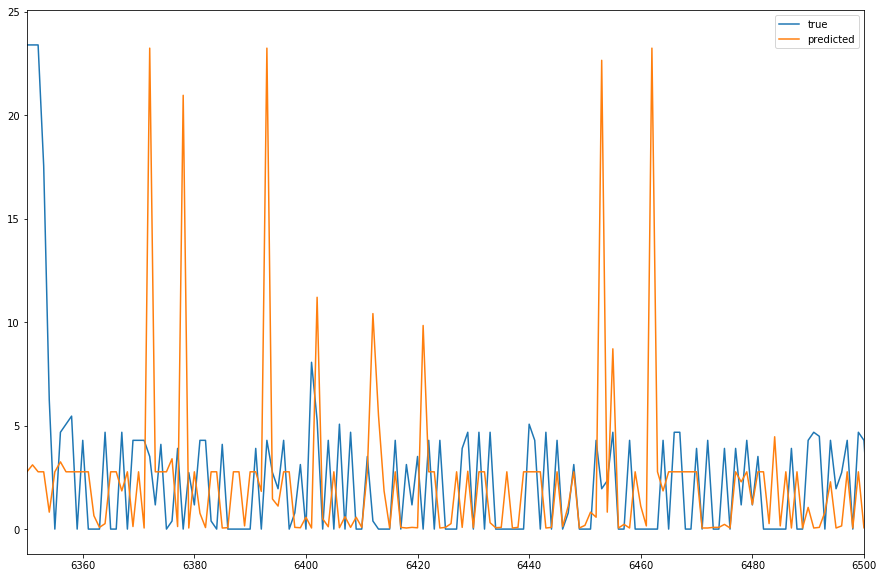

In [201]:
# compare predictions on train set with actual values

fig = plt.figure(figsize=(15,10))

plt.plot(final, label='true')
plt.plot(trainPredict2, label='predicted')
# plt.plot(testPredict)
plt.legend()
plt.xlim(6350, 6500)

### complete bullshit follows lol

In [85]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(data_shift_dum)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[24:len(trainPredict)+24, :] = trainPredict

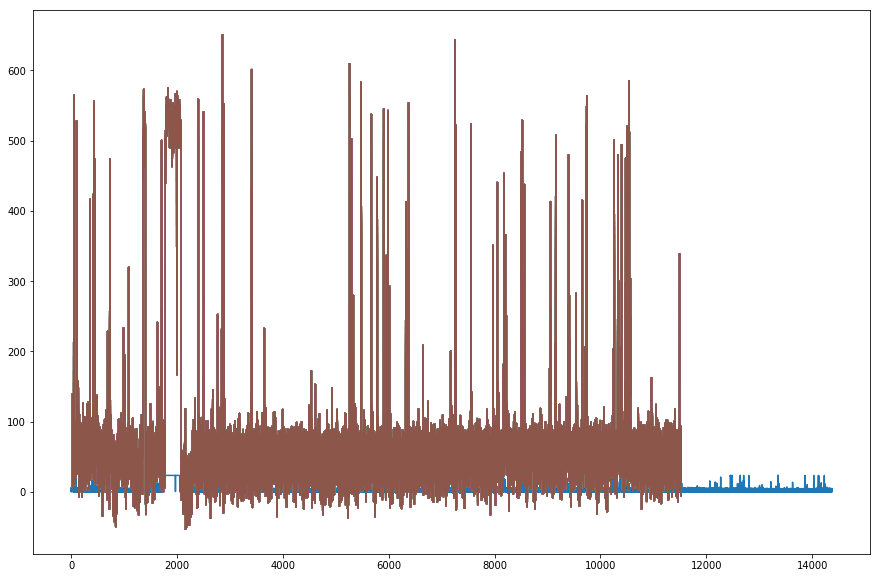

In [86]:
fig = plt.figure(figsize=(15,10))
plt.plot(final)
plt.plot(trainPredictPlot)
# plt.plot(testPredictPlot)
plt.show()

In [84]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(data_shift_dum)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(24*2)+1:len(data_shift_dum)-1, :] = testPredict
# plot baseline and predictions
fig = plt.figure(figsize=(15,10))
plt.plot(final)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

ValueError: could not broadcast input array from shape (2876,1) into shape (2826,75)

In [91]:
org_flow = new_data['norm_flow'].to_numpy().reshape(-1, 1)
# org_flow = scaler.inverse_transform(org_flow)
# final = org_flow[23:]
# final.shape

In [81]:
trainPredict.shape, testPredict.shape

((11500, 1), (2876, 1))

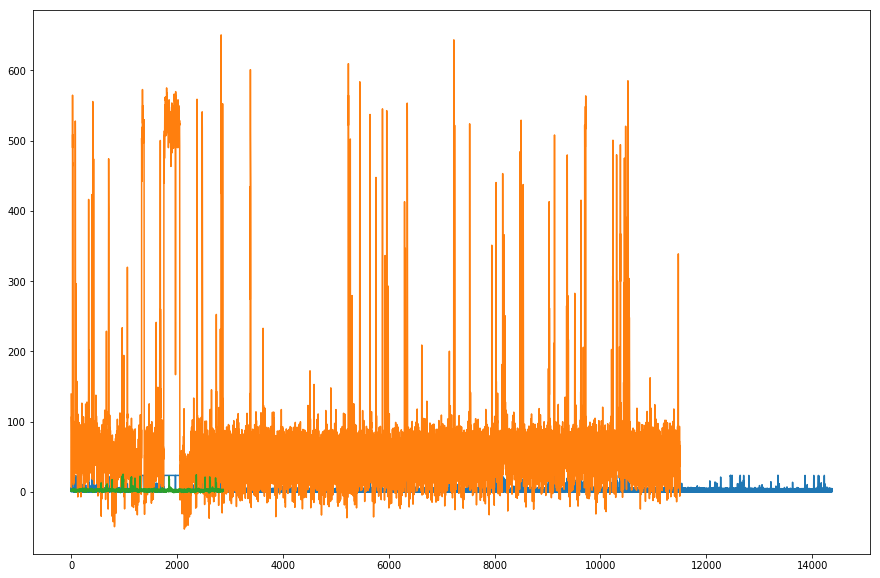

In [82]:
fig = plt.figure(figsize=(15,10))
plt.plot(final)
plt.plot(trainPredict)
plt.plot(testPredict)
plt.show()

# results
- run without dummies i think
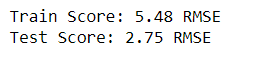